### GEOG0051

Mining Social and Geographic Datasets
-----------------------------------

Machine Learning Analysis with Venue Review Data in Calgary, Canada
-------------------------------

Stephen Law, Igor Tkalec, Thomas Keel, and Gong Jie

For this second task, we would like you to analyse a dataset that contains review data of different venues in the city of Calgary,
Canada. With the help of several machine learning techniques that we have learnt in the course, you will be tasked to distill
insights from this social media dataset. Two of its notable features are the geocoding of every reviewed venues and the
availability of a considerable amount of text data in it, which lend to its ability to be processed using spatial and text analysis
techniques respectively.

As a prelude to the analysis prompts below, have a brief think about some of these questions: What can we discover about the
venue review data? Are there any spatial patterns that can be extracted from the data? Can we build a machine learning model
that predicts review rating for unseen data points using the text of the reviews?

### 3.1 Format of Data

The variables contained in the dataset provided in the `Calgary.csv` file, are:

* `business_id`, unique identifier of the premise
* `Name`, name of premise
* `latitude`, `longitude`, i.e. the locational attributes of the venue. <br/>
* `review_count` or the number of reviews the venue has been given<br/>
* `categories` general category of establishment that a venue falls under 
(Note: this variable is rather messy and might needs some cleaning/consolidation to be usable)<br/>
* `hours` or the opening hours of the venue <br/>
* `review_id` unique identifier of the review <br/>
* `user_id` unique identifier of the individual who left the review<br/>
* `stars_y` individual ratings of the venue<br/>
* `useful`, `funny`, `cool`, i.e. tags that the user attached to the review<br/>
* `text`, text of the review <br/>
* `date` i.e. the date of the review<br/>

In [1]:
#importing necessary packages for this project

##data managament

import numpy as np #for numeric calculations with more complex data structures
import pandas as pd #for data importing, wrangling and cleaning

##data visualisation

import matplotlib.pyplot as plt #for plots and data visualisation
import seaborn as sns #for plots and data visualisation
import geopandas as gpd #for geospatial data management and mapping
import contextily as ctx #for retrieving basemaps from the internet
import scipy.stats #shapiro-wilk test for normality
from scipy.stats import norm #for normal distribution curve



##feature engineering

from scipy.stats import skew #check for skewness
from sklearn.preprocessing import StandardScaler #standard scaler of variables

##analysis

from sklearn.model_selection import train_test_split #splitting dataset into train and split before modelling
from sklearn import metrics #metics
from sklearn.model_selection import cross_validate #cross validation
from sklearn.model_selection import GridSearchCV #grid search
from sklearn.model_selection import RandomizedSearchCV # randomized search
from sklearn.model_selection import KFold #kfold
from sklearn.feature_selection import RFE #rfe

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


from sklearn.datasets import fetch_20newsgroups
from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression

from wordcloud import WordCloud


##ignore warnings

import warnings
warnings.filterwarnings(action='ignore')

## 1. Data Importing

In [2]:
calgary = pd.read_csv("Data/Calgary.csv")
calgary.head()

,business_id,name,latitude,longitude,review_count,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date
0,MbZMmwo-eL0Jnm_Yb9KJrA,Chinook Landscaping and Design,50.94596,-114.037207,3,"Contractors, Landscaping, Home Services","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...",pltqT0DnejbWN-K32BD1Fg,v6zuRbp5jjHroawRiv9IhQ,5.0,1,0,0,David came in the spring to give me an estimat...,2017-08-16 01:10:52
1,MbZMmwo-eL0Jnm_Yb9KJrA,Chinook Landscaping and Design,50.94596,-114.037207,3,"Contractors, Landscaping, Home Services","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...",8Iaf1YXNjo3zPd6-uLSJhg,UkL35C-EXA_yje4HeNINeQ,5.0,0,0,0,Chinook Landscaping is a Company that I would ...,2014-06-15 21:09:06
2,MbZMmwo-eL0Jnm_Yb9KJrA,Chinook Landscaping and Design,50.94596,-114.037207,3,"Contractors, Landscaping, Home Services","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...",fTU0yYLj78NJftEKah-woQ,CXhdG2DP0aplOZPZtNFobw,5.0,0,0,0,Chinook Landscaping is tops in my book\nI was ...,2013-08-22 22:10:38
3,rdg0b0tHKvSCQNl6u3tS_A,SML Entertainment,51.08499,-113.989605,5,"Shopping, Caterers, Furniture Stores, Hot Tub ...","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",2SGfqlKDjuFpXZ7LjdNJSQ,siNu6MF02MSMnoyPkaxZyg,5.0,5,0,0,If you are looking for a supplier of games tab...,2009-06-29 02:20:25
4,rdg0b0tHKvSCQNl6u3tS_A,SML Entertainment,51.08499,-113.989605,5,"Shopping, Caterers, Furniture Stores, Hot Tub ...","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",5RfnOMsGcQ26EoXlteFOyw,-InhDRRVG7wrwsgAUvN4Qw,5.0,6,3,3,"SML is now a personal wet dream of mine, the e...",2009-12-03 17:29:51


In [3]:
calgary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82182 entries, 0 to 82181
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   82182 non-null  object 
 1   name          82182 non-null  object 
 2   latitude      82182 non-null  float64
 3   longitude     82182 non-null  float64
 4   review_count  82182 non-null  int64  
 5   categories    82182 non-null  object 
 6   hours         82182 non-null  object 
 7   review_id     82182 non-null  object 
 8   user_id       82182 non-null  object 
 9   stars_y       82182 non-null  float64
 10  useful        82182 non-null  int64  
 11  funny         82182 non-null  int64  
 12  cool          82182 non-null  int64  
 13  text          82182 non-null  object 
 14  date          82182 non-null  object 
dtypes: float64(3), int64(4), object(8)
memory usage: 9.4+ MB


## 2. Data Wrangling and Exploration

In [4]:
#number of rows and columns in property dataset

calgary.shape

(82182, 15)

#### 2.1.1 Descriptive Statistics of London Housing Dataset

In [5]:
#have a look at descriptive statistics of property data
calgary.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,82182.0,51.042724,0.051552,50.865169,51.033200,51.044727,51.066428,51.20754
longitude,82182.0,-114.070648,0.053040,-114.379523,-114.086896,-114.070254,-114.053056,-113.71414
review_count,82182.0,61.995254,77.290191,3.000000,13.000000,36.000000,78.000000,512.00000
stars_y,82182.0,3.618639,1.424214,1.000000,3.000000,4.000000,5.000000,5.00000
useful,82182.0,1.293203,2.830347,0.000000,0.000000,0.000000,2.000000,104.00000
funny,82182.0,0.391083,1.306604,0.000000,0.000000,0.000000,0.000000,59.00000
cool,82182.0,0.382578,1.171075,0.000000,0.000000,0.000000,0.000000,69.00000


In [6]:
#checking for duplicates
calgary.duplicated().value_counts()

False    82182
dtype: int64

In [7]:
calgary.drop_duplicates(inplace=True)

In [8]:
calgary.isnull().value_counts()

business_id  name   latitude  longitude  review_count  categories  hours  review_id  user_id  stars_y  useful  funny  cool   text   date 
False        False  False     False      False         False       False  False      False    False    False   False  False  False  False    82182
dtype: int64

#### 2.1.4 Converting London Housing data into spatial point data


In [9]:
#convert df into gdf using easting and northings 
#project the gdf into British National Grid (27700)

calgary_gdf = gpd.GeoDataFrame(
    calgary, 
    geometry=gpd.points_from_xy(calgary.longitude, 
                                      calgary.latitude)).set_crs(epsg=4326)

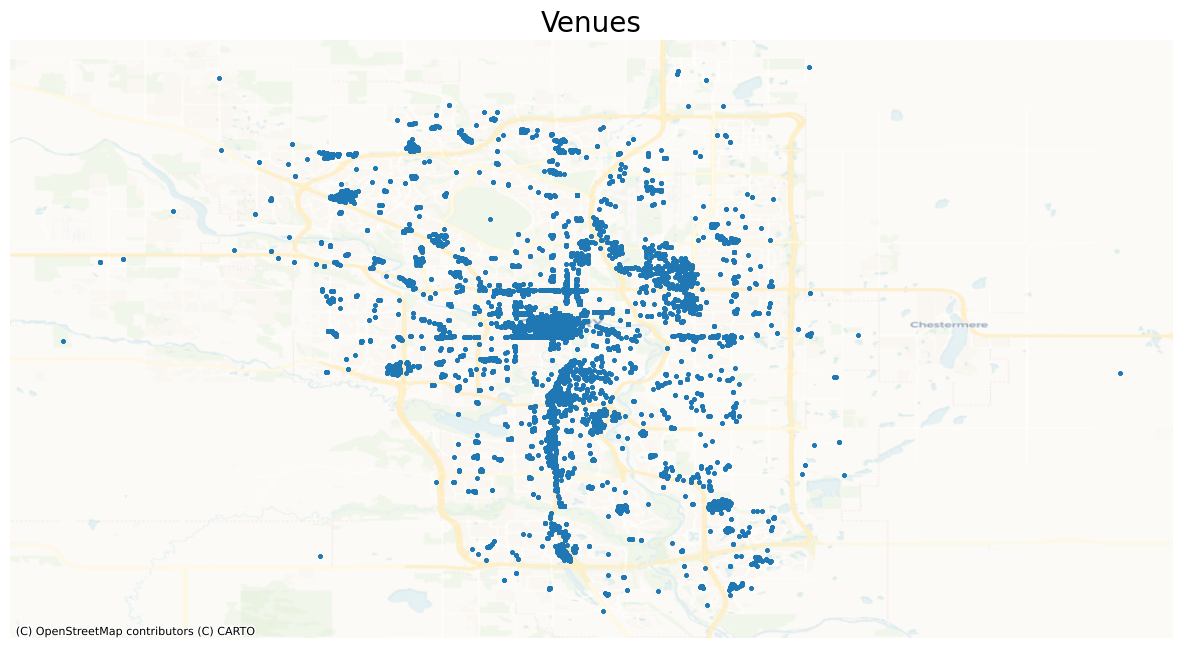

In [10]:
#mapping housing price distribution in London without dealing with outliers

fig, ax = plt.subplots(figsize=(15, 15))


ax.set_aspect('equal')



calgary_gdf.plot(ax=ax,marker='o', markersize=5,legend=True)


# this adds the basemap
ctx.add_basemap(ax, crs=calgary_gdf.crs, alpha=0.6, source=ctx.providers.CartoDB.Voyager)

# this sets the title
ax.set_title("Venues",fontsize= 20)

# this removes the axis
ax.set_axis_off()

In [50]:
calgary_gdf["polarity"] = None

for rate in range(len(calgary_gdf["stars_y"])):
    if calgary_gdf["stars_y"][rate] > 3:
        calgary_gdf["polarity"][rate] = 1
    else:
        calgary_gdf["polarity"][rate] = 0

In [ ]:
calgary_gdf.head()

In [58]:
calgary_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 82182 entries, 0 to 82181
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   business_id   82182 non-null  object  
 1   name          82182 non-null  object  
 2   latitude      82182 non-null  float64 
 3   longitude     82182 non-null  float64 
 4   review_count  82182 non-null  int64   
 5   categories    82182 non-null  object  
 6   hours         82182 non-null  object  
 7   review_id     82182 non-null  object  
 8   user_id       82182 non-null  object  
 9   stars_y       82182 non-null  float64 
 10  useful        82182 non-null  int64   
 11  funny         82182 non-null  int64   
 12  cool          82182 non-null  int64   
 13  text          82182 non-null  object  
 14  date          82182 non-null  object  
 15  geometry      82182 non-null  geometry
 16  polarity      82182 non-null  object  
dtypes: float64(3), geometry(1), int64(4), obje

In [59]:
calgary_gdf["polarity"] = calgary_gdf["polarity"].astype('int')

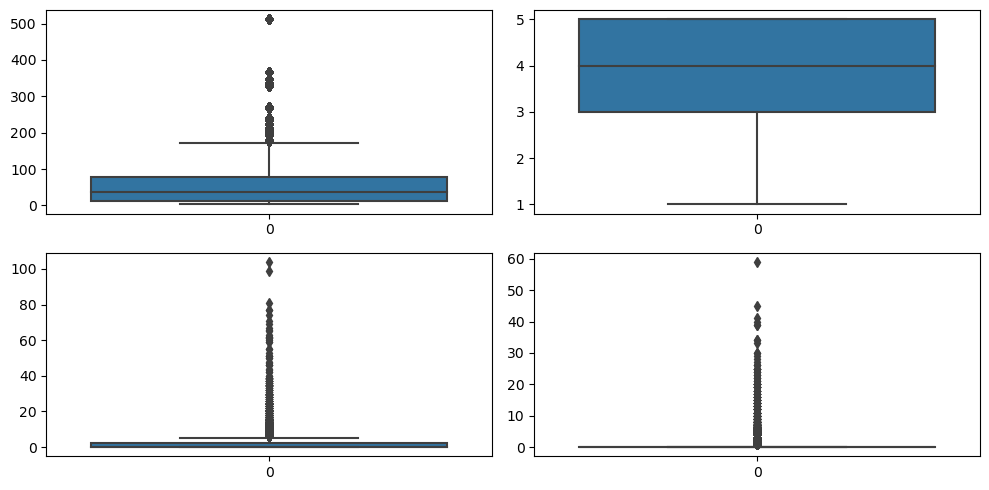

In [11]:
#have a look at outliers of price, total floor area, number of rooms and current energy efficiency

fig, axs = plt.subplots(2,2, figsize = (10,5))
plt1 = sns.boxplot(calgary_gdf['review_count'], ax = axs[0,0])
plt2 = sns.boxplot(calgary_gdf['stars_y'], ax = axs[0,1])
plt3 = sns.boxplot(calgary_gdf['useful'], ax = axs[1,0])
plt4 = sns.boxplot(calgary_gdf['funny'], ax = axs[1,1])

plt.tight_layout()

<AxesSubplot: xlabel='stars_y', ylabel='count'>

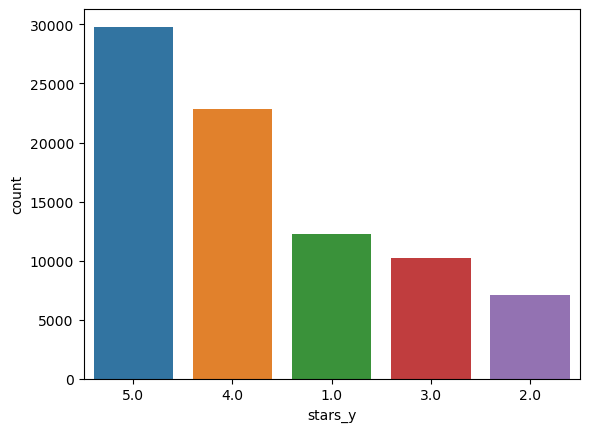

In [41]:

sns.countplot(calgary_gdf,
              x='stars_y',
              order=calgary_gdf["stars_y"].value_counts().index)

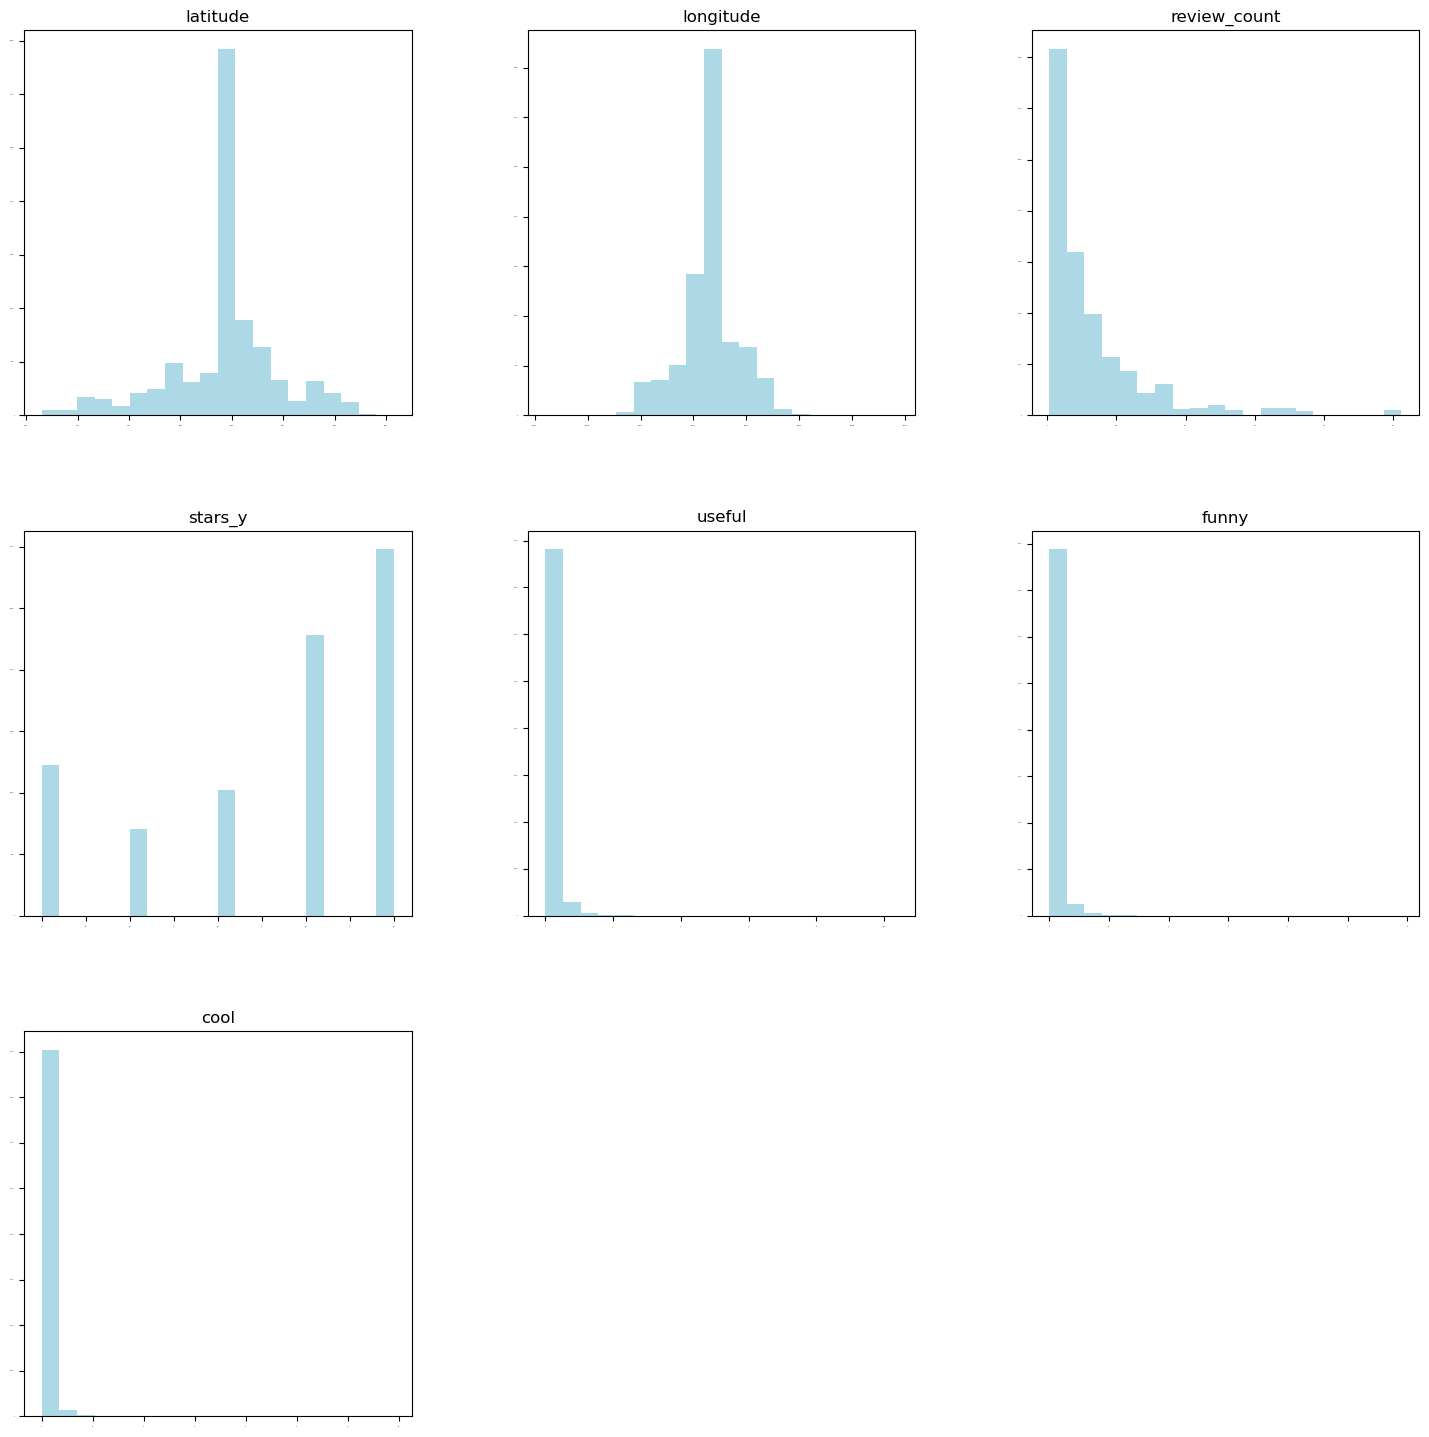

In [13]:
calgary_gdf.hist(bins=20,
       figsize=(18,18), 
       color='lightblue', 
       xlabelsize=0, 
       ylabelsize=0, 
       grid=False
      )
plt.show()

In [14]:
#grouping housing price values by London boroughs 

group =calgary_gdf.groupby(["business_id","name","latitude","longitude"])["review_count"].agg(["count",min,max,"median","mean"]).reset_index()
group

,business_id,name,latitude,longitude,count,min,max,median,mean
0,--1UhMGODdWsrMastO9DZw,The Spicy Amigos,51.049673,-114.079977,29,27,27,27.0,27.0
1,--YPwqIlRJrhHkJcjY3eiA,That Old Retro Store,51.041015,-114.033419,3,3,3,3.0,3.0
2,-0RU0vASJOV383dYA8VZgA,Pho Hoan Pasteur,50.898863,-113.941861,15,15,15,15.0,15.0
3,-1u4Q4U6OZ-CvqoxUh7gKg,Las Canarias,51.037654,-114.088942,25,25,25,25.0,25.0
4,-2C96suwzrE_cqI1U69cLA,Open Sesame,50.992148,-114.070811,74,73,73,73.0,73.0
...,...,...,...,...,...,...,...,...,...
5229,zwEHPvXH0H-ZjRP-MkIdmw,Salon Luminous,51.015451,-114.175243,4,4,4,4.0,4.0
5230,zwFScgZRXOsWnucfwyn8pw,Nottinghams Pub & Restaurant,51.116559,-114.204570,22,21,21,21.0,21.0
5231,zxT_TuVfr_7OgGdZNyIwyw,Dublin Calling,51.038428,-114.141595,5,4,4,4.0,4.0
5232,zxl5OV08TBaEg43X3p7_Ng,Acclaim Hotel Calgary Airport,51.150411,-113.999658,24,24,24,24.0,24.0


In [15]:
group["count"].mean()

15.701566679403898

<AxesSubplot: >

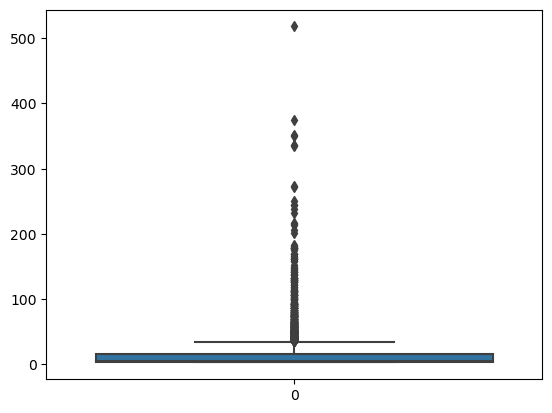

In [16]:
sns.boxplot(group["count"])

In [17]:
calgary_gdf[calgary_gdf["review_count"]>101].info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 15230 entries, 755 to 81915
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   business_id   15230 non-null  object  
 1   name          15230 non-null  object  
 2   latitude      15230 non-null  float64 
 3   longitude     15230 non-null  float64 
 4   review_count  15230 non-null  int64   
 5   categories    15230 non-null  object  
 6   hours         15230 non-null  object  
 7   review_id     15230 non-null  object  
 8   user_id       15230 non-null  object  
 9   stars_y       15230 non-null  float64 
 10  useful        15230 non-null  int64   
 11  funny         15230 non-null  int64   
 12  cool          15230 non-null  int64   
 13  text          15230 non-null  object  
 14  date          15230 non-null  object  
 15  geometry      15230 non-null  geometry
dtypes: float64(3), geometry(1), int64(4), object(8)
memory usage: 2.0+ MB


In [18]:
group_stars =calgary_gdf.groupby(["business_id","name","latitude","longitude"])["stars_y"].agg(["count",min,max,"median","mean"]).reset_index()
group_stars

,business_id,name,latitude,longitude,count,min,max,median,mean
0,--1UhMGODdWsrMastO9DZw,The Spicy Amigos,51.049673,-114.079977,29,1.0,5.0,4.0,4.068966
1,--YPwqIlRJrhHkJcjY3eiA,That Old Retro Store,51.041015,-114.033419,3,1.0,4.0,1.0,2.000000
2,-0RU0vASJOV383dYA8VZgA,Pho Hoan Pasteur,50.898863,-113.941861,15,1.0,5.0,4.0,3.333333
3,-1u4Q4U6OZ-CvqoxUh7gKg,Las Canarias,51.037654,-114.088942,25,1.0,5.0,5.0,4.080000
4,-2C96suwzrE_cqI1U69cLA,Open Sesame,50.992148,-114.070811,74,1.0,5.0,4.0,3.445946
...,...,...,...,...,...,...,...,...,...
5229,zwEHPvXH0H-ZjRP-MkIdmw,Salon Luminous,51.015451,-114.175243,4,1.0,5.0,3.0,3.000000
5230,zwFScgZRXOsWnucfwyn8pw,Nottinghams Pub & Restaurant,51.116559,-114.204570,22,1.0,5.0,4.0,3.409091
5231,zxT_TuVfr_7OgGdZNyIwyw,Dublin Calling,51.038428,-114.141595,5,2.0,3.0,2.0,2.200000
5232,zxl5OV08TBaEg43X3p7_Ng,Acclaim Hotel Calgary Airport,51.150411,-113.999658,24,1.0,5.0,4.0,3.875000


In [19]:
#convert df into gdf using easting and northings 
#project the gdf into British National Grid (27700)

group_stars_gdf = gpd.GeoDataFrame(
    group_stars, 
    geometry=gpd.points_from_xy(group_stars.longitude, 
                                      group_stars.latitude)).set_crs(epsg=4326)

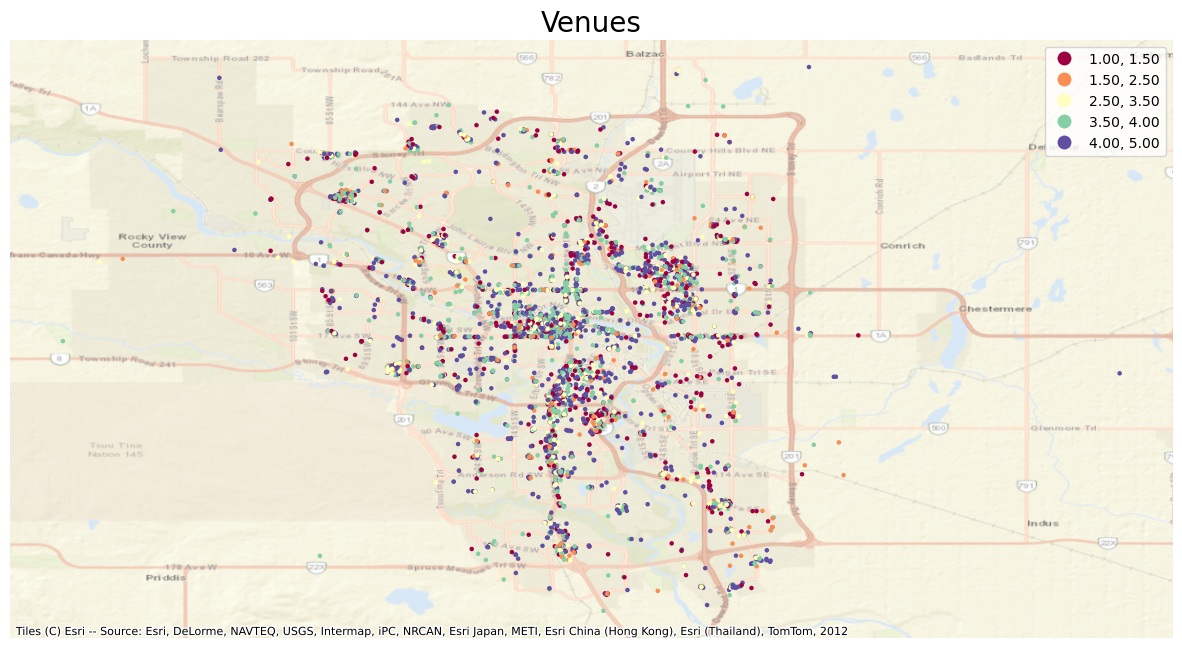

In [20]:
#mapping housing price distribution in London without dealing with outliers

fig, ax = plt.subplots(figsize=(15, 15))


ax.set_aspect('equal')


group_stars_gdf.plot(ax=ax,marker='o',column="median",scheme = "NaturalBreaks", cmap="Spectral", markersize=5,legend=True)

ctx.add_basemap(ax, crs=group_stars_gdf.crs, alpha=0.6, source=ctx.providers.Esri.WorldStreetMap)


# this sets the title
ax.set_title("Venues",fontsize= 20)

# this removes the axis
ax.set_axis_off()

## 3.2.2 Build a supervised learning model for text analysis

In [60]:
import nltk
from nltk.stem import WordNetLemmatizer

# word n-gram (default)
vectorizer = CountVectorizer(analyzer='word',lowercase=True, min_df=2, stop_words='english',max_features=5000)
X = vectorizer.fit_transform(calgary_gdf["text"])

wor = vectorizer.get_feature_names_out()


bag_of_words = pd.DataFrame(X.toarray(),columns=[wor])

X

<82182x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 3306917 stored elements in Compressed Sparse Row format>

In [61]:
wor

array(['00', '000', '00pm', ..., 'zone', 'zoo', 'zucchini'], dtype=object)

https://www.geeksforgeeks.org/flipkart-reviews-sentiment-analysis-using-python/?ref=rp

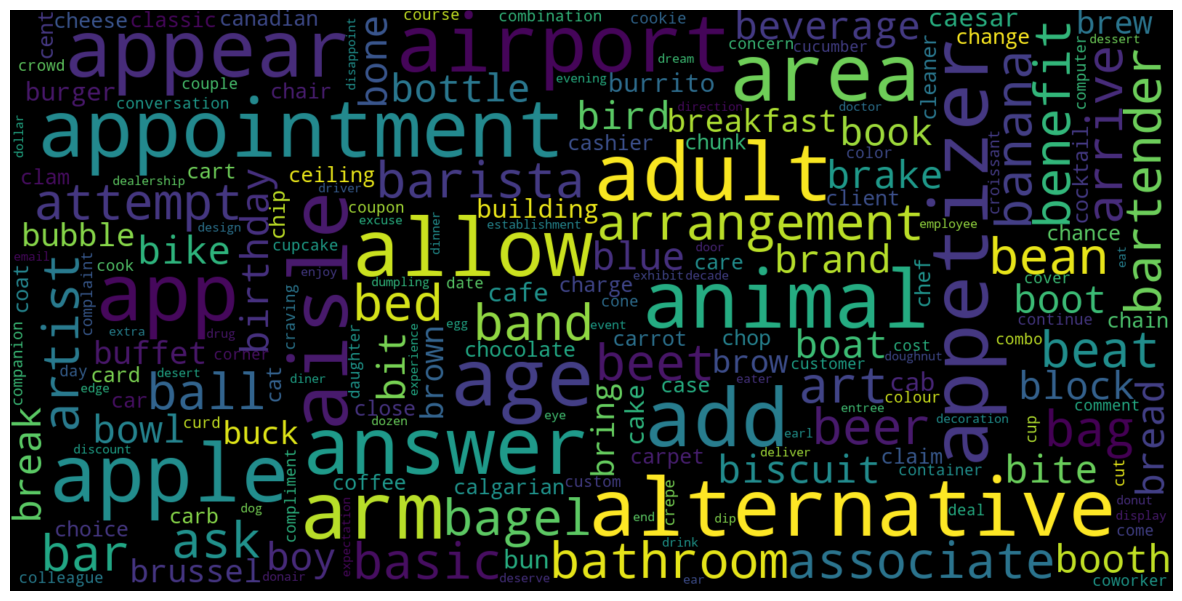

In [23]:
consolidated = ' '.join(
    word for word in wor.astype(str))
wordCloud = WordCloud(width=1600, height=800,
                      random_state=21, max_font_size=110)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

In [62]:
# this gets the training set and vectorise it
X_train, X_test, y_train, y_test = train_test_split(X, calgary_gdf['polarity'],
                                                    test_size=0.30,
                                                    stratify=calgary_gdf['polarity'],
                                                    random_state = 42)
X_train

<57527x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 2312119 stored elements in Compressed Sparse Row format>

In [64]:
from sklearn.tree import DecisionTreeClassifier
  
model = DecisionTreeClassifier(random_state=0)
model.fit(X_train,y_train)
  
#testing the model
pred = model.predict(X_test)
print(accuracy_score(y_test,pred))

0.7601703508416143


In [65]:
# this fit the Naive Bayes Classifier
clf = MultinomialNB()
clf.fit(X_train,y_train)

# this uses the Naive Bayes Classifier to predict
y_pred = clf.predict(X_test)

# this prints the f1_score 
print (f1_score(y_test, y_pred, average='macro'))
print (accuracy_score(y_test, y_pred))

0.8093283291898836
0.8277428513486108


<AxesSubplot: >

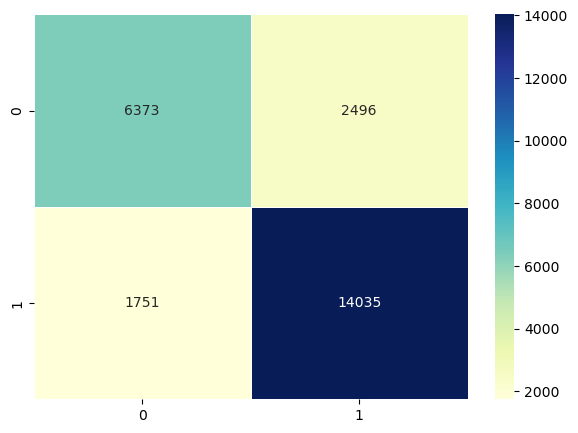

In [66]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#creates a grid to plot on
f, ax = plt.subplots(figsize=(7, 5))
#plots confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred),annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")